README: updated: 
- use all data instead of just sample data
- combine time feature modeling + property feature modeling 

In [1]:
import os
os.chdir('/Users/liyuan/desktop/SI699/codes')
import pandas as pd
import numpy as np
import time

from ts_modeling_v2 import TsModeling
from reformat_data_by_day import Reformat_data
from time_feature_modeling import TimeFeatureModeling
from help import sample_data, get_rmse, get_predictions,extract_time_features

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load all data
train = pd.read_csv('../expedia_data/train.csv')
test = pd.read_csv('../expedia_data/test.csv')
cols_train_only = [col for col in train.columns.unique().tolist() if col not in test.columns.unique().tolist()]
train = train.drop(columns = cols_train_only)
all_data = pd.concat([train, test], ignore_index=True)

In [3]:
print('there are %d records in train and test data combined' % len(all_data))

there are 16540159 records in train and test data combined


there are 140821 property id
property 116942 has 7383 records
property 116942 has 242 records by day


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:76: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


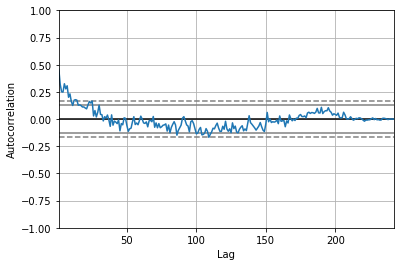

training size: 155
validation size: 38
test size: 48
plot for ARIMA model ...
training size: 155
validation size: 38
test size: 48


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

RMSE: 19.743


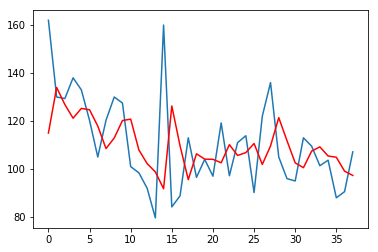

RMSE: 16.756


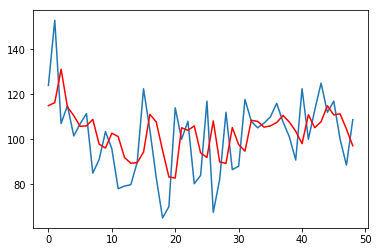

In [84]:
# get data by property_id
prop_id_lst = all_data['prop_id'].unique().tolist()
print('there are %d property id'%len(prop_id_lst))

# get data by property id
prop_data = all_data[all_data['prop_id'] == 116942]
print('property 116942 has %d records' % len(prop_data))

# get daily property data
tsm = TsModeling()
prop_data = tsm.process_data_by_prop(prop_data)
daily_price = prop_data[['price_usd']].resample('D').median()
print('property 116942 has %d records by day'% len(daily_price))

# fit ARIMA
tsm.get_auto_correlation(daily_price)
train, val, test = tsm.split_data(daily_price) # split X
print('plot for ARIMA model ...')
val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)

   date_time  price_usd  day  week  month  quarter
0 2012-11-01    105.000    1    44     11        4
1 2012-11-02    105.000    2    44     11        4
2 2012-11-03    127.140    3    44     11        4
3 2012-11-04     91.380    4    44     11        4
4 2012-11-05     91.605    5    45     11        4
price data len: 242
242
variance of data: 357

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe


training size: 155
validation size: 38
test size: 48
training RMSE: 16.352462388808384
valiation RMSE: 22.87300786282893
test RMSE: 20.36747232790119


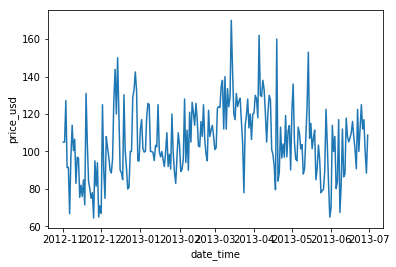

In [85]:
# fit regression model on daily_price
daily_price = extract_time_features(daily_price)
print(daily_price.head())
regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(daily_price.dropna())
# print(regression_y_pred_train, regression_y_pred_val, regression_y_pred_test)

In [86]:
# task: second-layer modeling (XGBoost)
# has finished basic parameter tuning
model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 25) 
y_pred_train, y_pred_test = tsm.second_layer_modeling(model)

(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 18
test rmse: 17


In [87]:
# checking
print(y_pred_train.shape)
print(y_pred_test.shape)

(38,)
(49,)


In [88]:
from sklearn.metrics import mean_squared_error
import numpy as np

def get_rmse(pred, true):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

In [89]:
# task: combine property modeling + time modeling
# get prediction results from Crystal's codes
y_pred_train_prop = pd.read_csv('../res/ElasticNet_y_pred_val.csv').values.ravel()
y_pred_test_prop = pd.read_csv('../res/ElasticNet_y_pred_test.csv').values.ravel()

# reshape predictions from time modeling
y_pred_train_ = y_pred_train.reshape(-1,1)
y_pred_test_ = y_pred_test.reshape(-1,1)

# reshape predictions from propery modeling
print(y_pred_train_prop.shape)
print(y_pred_test_prop.shape)
y_pred_train_prop_ = y_pred_train_prop.reshape(-1,1)
y_pred_test_prop_ = y_pred_test_prop.reshape(-1,1)

# combine predictions results with my codes
X_train = np.concatenate(( y_pred_train_prop_, y_pred_train_), axis=1)
X_test = np.concatenate(( y_pred_test_prop_, y_pred_test_), axis=1)
# get y_train, y_test
y_train = tsm.val
y_test = tsm.test

(38,)
(49,)


In [96]:
# task: fit third-layer model
# model = LinearRegression()
# model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
model = RandomForestRegressor()

reg = model.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
# get rmse
train_RMSE = get_rmse(y_pred_train ,y_train)
test_RMSE = get_rmse(y_pred_test ,y_test)
print('train rmse: %d'%train_RMSE)
print('test rmse: %d'%test_RMSE)

train rmse: 5
test rmse: 22


/anaconda3/envs/leetcode/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
